In [61]:
# Load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
#Loading the datasets
transaction_data = pd.read_excel("QVI_transaction_data.xlsx")
customer_data = pd.read_csv("QVI_purchase_behaviour.csv")

In [3]:
#Examining the transaction data
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [4]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
#Checking for missing values
transaction_data.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [6]:
# Convert DATE column to a date format
transaction_data["DATE"] = pd.to_datetime(transaction_data["DATE"], origin='1899-12-30', unit='D')
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [7]:
# Examine PROD_NAME
transaction_data['PROD_NAME'].value_counts()

PROD_NAME
Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
                                            ... 
RRD Pc Sea Salt     165g                    1431
Woolworths Medium   Salsa 300g              1430
NCC Sour Cream &    Garden Chives 175g      1419
French Fries Potato Chips 175g              1418
WW Crinkle Cut      Original 175g           1410
Name: count, Length: 114, dtype: int64

In [8]:
# Further examine PROD_NAME
product_words = pd.DataFrame(transaction_data['PROD_NAME'].str.split().explode().value_counts()).reset_index()

#str.split(): splits each product name into individual words
#explode(): After splitting, to transform each element of a list-like column into a row, effectively flattening the lists so each word has its own row.
#value_counts(): counts the occurrences of each word across all product names.
#pd.DataFrame(...).reset_index(): Converts the result into a DataFrame and resets the index to get a well-structured DataFrame.

product_words.columns = ['words', 'count']

#This renames the columns - one column contains words and the other contains their respective counts.


In [9]:
# Remove digits and special characters
product_words = product_words[~product_words['words'].str.contains(r'\d|%')]

# contains() - checks each entry in the 'words' column to see if it contains any digit (\d) or the % character
# ~  - bitwise not- to negate the condition, so that only words without digits or % are kept.

In [10]:
# Summarise the data to check for nulls and possible outliers
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,2018-12-30 00:52:12.879215616,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200
min,2018-07-01 00:00:00,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,2018-09-30 00:00:00,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,2018-12-30 00:00:00,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,2019-06-30 00:00:00,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226


In [11]:
# Filter the dataset to find the outlier
outlier_transactions = transaction_data[transaction_data['PROD_QTY'] == 200] #max is 200
outlier_transactions

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [12]:
# Remove the outlier customer
transaction_data = transaction_data[~transaction_data['LYLTY_CARD_NBR'].isin(outlier_transactions['LYLTY_CARD_NBR'])]
#If Loyaltycard no in outlier transactions = True, don't include in transaction data

In [13]:
# Count the number of transactions by date
transactions_by_day = transaction_data.groupby('DATE').size().reset_index(name='N')

#transaction_data - groupedby the 'DATE' column
# size() - creates a series - counts the number of transactions for each date
# reset_index() - creates a new DataFrame with two columns: 'DATE' and 'N'(count of transactions)

#This can be very useful for analyzing transaction patterns over time.
transactions_by_day

,DATE,N
0,2018-07-01,724
1,2018-07-02,711
2,2018-07-03,722
3,2018-07-04,714
4,2018-07-05,712
...,...,...
359,2019-06-26,723
360,2019-06-27,709
361,2019-06-28,730
362,2019-06-29,745


In [19]:
# Create a sequence of dates and join this to the count of transactions by date
date_range = pd.date_range(start='2018-07-01', end='2019-06-30')
transactions_by_day = transactions_by_day.set_index('DATE').reindex(date_range).fillna(0).reset_index()
transactions_by_day.columns = ['DATE', 'N']
transactions_by_day.head()

#date_range - creates a sequence of dates from 1st July 2018 to 30th June 2019
#set_index('DATE') - sets the 'DATE' column as the index - useful for reindexing
#reindex(date_range) - reindexes the transactions_by_day DataFrame to align with the date_range
#It adds rows for any dates in the date_range that were not present in the original DataFrame and fills the corresponding 'N' values with NaN.
#fillna(0) - replaces the NaN values with 0
#reset_index() - resets the index (which is now the date_range) to get a well-structured DataFrame


#This ensures that you have a count of transactions for every day in the specified range, including days with no transactions

,DATE,N
0,2018-07-01,724.0
1,2018-07-02,711.0
2,2018-07-03,722.0
3,2018-07-04,714.0
4,2018-07-05,712.0


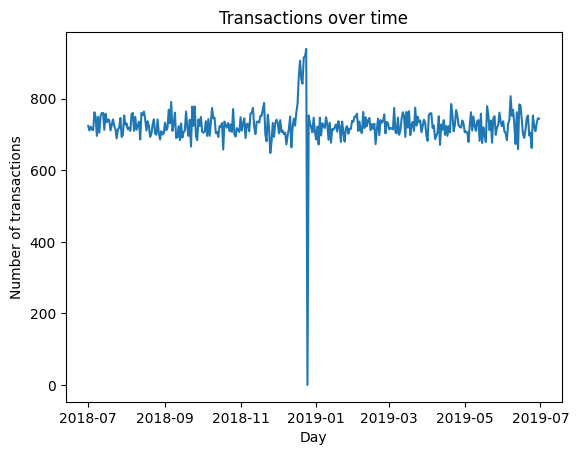

In [46]:
# Plot transactions over time
sns.lineplot(data=transactions_by_day, x='DATE', y='N')
plt.title('Transactions over time')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.show()

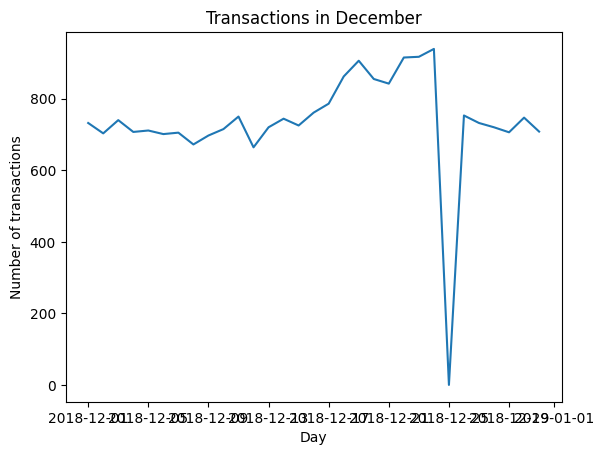

In [47]:
# Filter to December and look at individual days
december_transactions = transactions_by_day[transactions_by_day['DATE'].dt.month == 12] 
sns.lineplot(data=december_transactions, x='DATE', y='N')
plt.title('Transactions in December')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.show()

PACK_SIZE
70.0      1507
90.0      3008
110.0    22387
125.0     1454
134.0    25102
135.0     3257
150.0    40203
160.0     2970
165.0    15297
170.0    19983
175.0    66390
180.0     1468
190.0     2995
200.0     4473
210.0     6272
220.0     1564
250.0     3169
270.0     6285
330.0    12540
380.0     6416
Name: count, dtype: int64


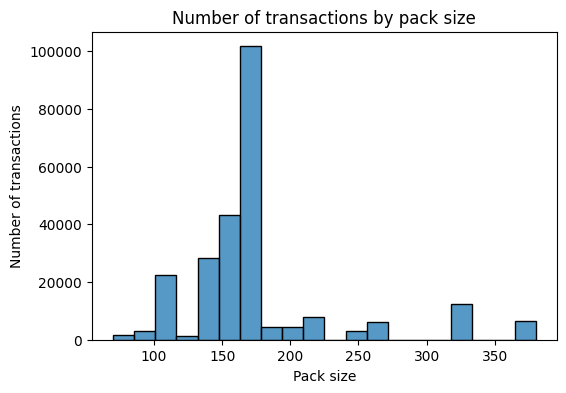

In [22]:
# Create pack size
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(float)
print(transaction_data['PACK_SIZE'].value_counts().sort_index())

# Plot a histogram of PACK_SIZE
plt.figure(figsize=(6, 4))
sns.histplot(transaction_data['PACK_SIZE'], bins=20)
plt.title('Number of transactions by pack size')
plt.xlabel('Pack size')
plt.ylabel('Number of transactions')
plt.show()


In [23]:
# Examining customer data
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [24]:
customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [48]:
# Merge transaction data to customer data
data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR', how='left')
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [49]:
#Check for missing values
data[data.isnull().any(axis=1)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER


In [28]:
# Save dataset as a csv
data.to_csv("QVI_data.csv", index=False)

                 LIFESTAGE PREMIUM_CUSTOMER  TOT_SALES
0   MIDAGE SINGLES/COUPLES           Budget   33345.70
1   MIDAGE SINGLES/COUPLES       Mainstream   84734.25
2   MIDAGE SINGLES/COUPLES          Premium   54443.85
3             NEW FAMILIES           Budget   20607.45
4             NEW FAMILIES       Mainstream   15979.70
5             NEW FAMILIES          Premium   10760.80
6           OLDER FAMILIES           Budget  156863.75
7           OLDER FAMILIES       Mainstream   96413.55
8           OLDER FAMILIES          Premium   75242.60
9    OLDER SINGLES/COUPLES           Budget  127833.60
10   OLDER SINGLES/COUPLES       Mainstream  124648.50
11   OLDER SINGLES/COUPLES          Premium  123537.55
12                RETIREES           Budget  105916.30
13                RETIREES       Mainstream  145168.95
14                RETIREES          Premium   91296.65
15          YOUNG FAMILIES           Budget  129717.95
16          YOUNG FAMILIES       Mainstream   86338.25
17        

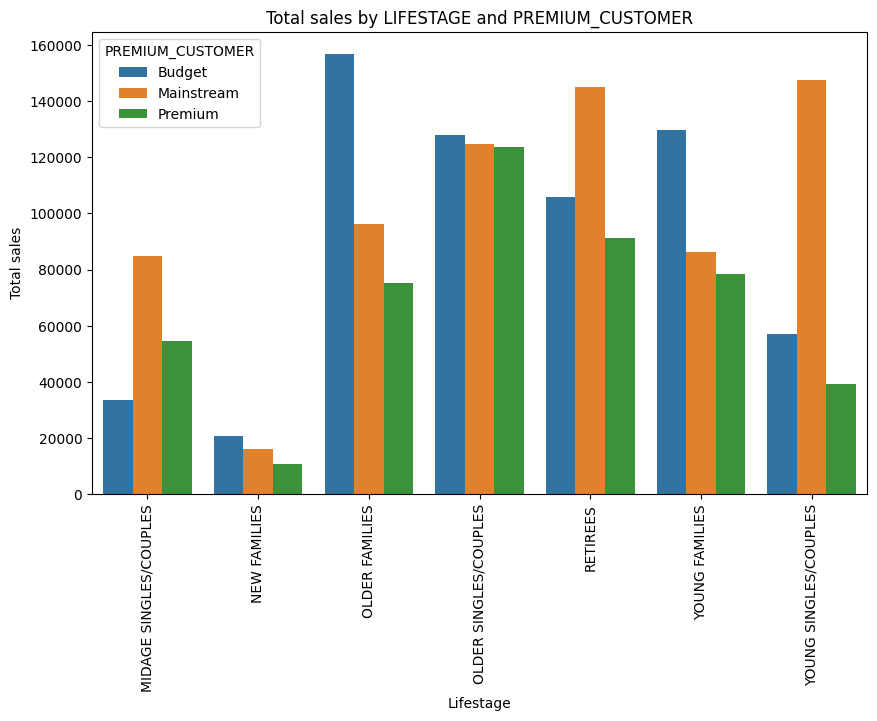

In [ ]:
# Data analysis on customer segments

# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
total_sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
print(total_sales)

#['TOT_SALES'].sum(): aggregates the total sales for each combination of LIFESTAGE and PREMIUM_CUSTOMER

plt.figure(figsize=(10, 6))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=total_sales)
plt.title('Total sales by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('Lifestage')
plt.ylabel('Total sales')
plt.xticks(rotation=90)
plt.show()

                 LIFESTAGE PREMIUM_CUSTOMER  LYLTY_CARD_NBR
0   MIDAGE SINGLES/COUPLES           Budget            1474
1   MIDAGE SINGLES/COUPLES       Mainstream            3298
2   MIDAGE SINGLES/COUPLES          Premium            2369
3             NEW FAMILIES           Budget            1087
4             NEW FAMILIES       Mainstream             830
5             NEW FAMILIES          Premium             575
6           OLDER FAMILIES           Budget            4611
7           OLDER FAMILIES       Mainstream            2788
8           OLDER FAMILIES          Premium            2231
9    OLDER SINGLES/COUPLES           Budget            4849
10   OLDER SINGLES/COUPLES       Mainstream            4858
11   OLDER SINGLES/COUPLES          Premium            4682
12                RETIREES           Budget            4385
13                RETIREES       Mainstream            6358
14                RETIREES          Premium            3812
15          YOUNG FAMILIES           Bud

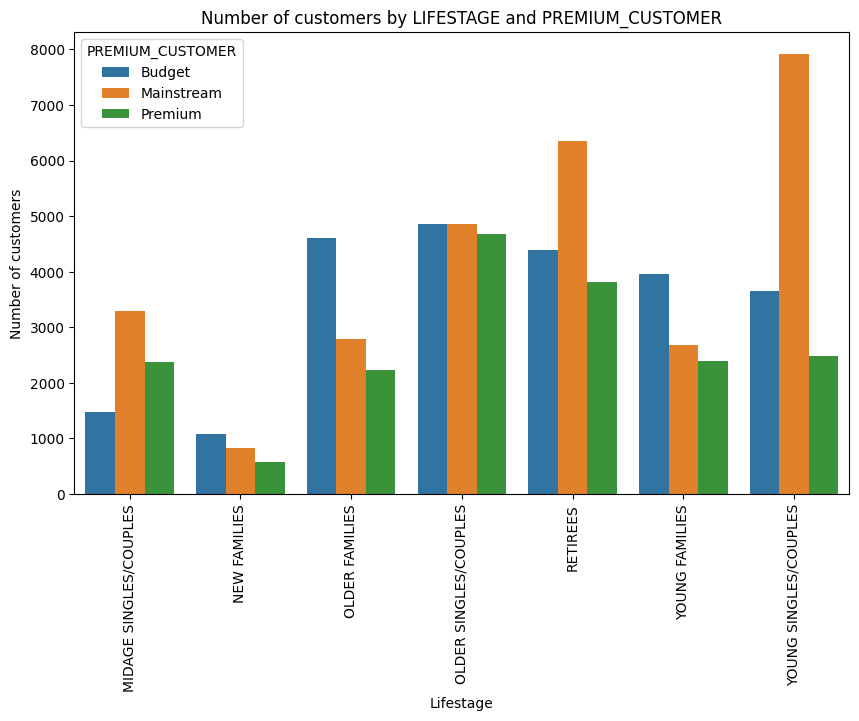

In [52]:
# Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
customer_count = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
print(customer_count)

plt.figure(figsize=(10, 6))
sns.barplot(x='LIFESTAGE', y='LYLTY_CARD_NBR', hue='PREMIUM_CUSTOMER', data=customer_count)
plt.title('Number of customers by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('Lifestage')
plt.ylabel('Number of customers')
plt.xticks(rotation=90)
plt.show()

                 LIFESTAGE PREMIUM_CUSTOMER  PROD_QTY
0   MIDAGE SINGLES/COUPLES           Budget  1.893626
1   MIDAGE SINGLES/COUPLES       Mainstream  1.911942
2   MIDAGE SINGLES/COUPLES          Premium  1.891750
3             NEW FAMILIES           Budget  1.855878
4             NEW FAMILIES       Mainstream  1.858124
5             NEW FAMILIES          Premium  1.860887
6           OLDER FAMILIES           Budget  1.945384
7           OLDER FAMILIES       Mainstream  1.948795
8           OLDER FAMILIES          Premium  1.945496
9    OLDER SINGLES/COUPLES           Budget  1.914920
10   OLDER SINGLES/COUPLES       Mainstream  1.911201
11   OLDER SINGLES/COUPLES          Premium  1.913949
12                RETIREES           Budget  1.893286
13                RETIREES       Mainstream  1.886680
14                RETIREES          Premium  1.901438
15          YOUNG FAMILIES           Budget  1.941226
16          YOUNG FAMILIES       Mainstream  1.941408
17          YOUNG FAMILIES  

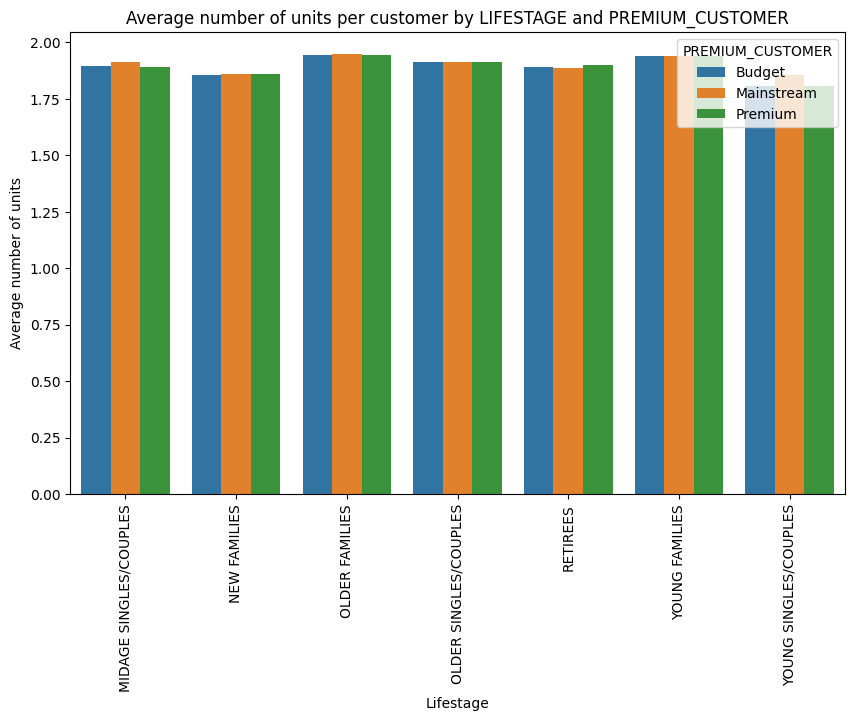

In [54]:
# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean().reset_index()
print(avg_units)
plt.figure(figsize=(10, 6))
sns.barplot(x='LIFESTAGE', y='PROD_QTY', hue='PREMIUM_CUSTOMER', data=avg_units)
plt.title('Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('Lifestage')
plt.ylabel('Average number of units')
plt.xticks(rotation=90)
plt.show()

        DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 2018-10-17          1            1000       1         5   
1 2019-05-14          1            1307     348        66   
2 2019-05-20          1            1343     383        61   
3 2018-08-17          2            2373     974        69   
4 2018-08-18          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0    Natural Chip        Compny SeaSalt175g         2        6.0      175.0   
1                  CCs Nacho Cheese    175g         3        6.3      175.0   
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9      170.0   
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0      175.0   
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8      150.0   

     BRAND               LIFESTAGE PREMIUM_CUSTOMER  PRICE_PER_UNIT  
0  Natural   YOUNG SINGLES/COUPLES          Premium            3.00  
1      CCs  MIDAGE

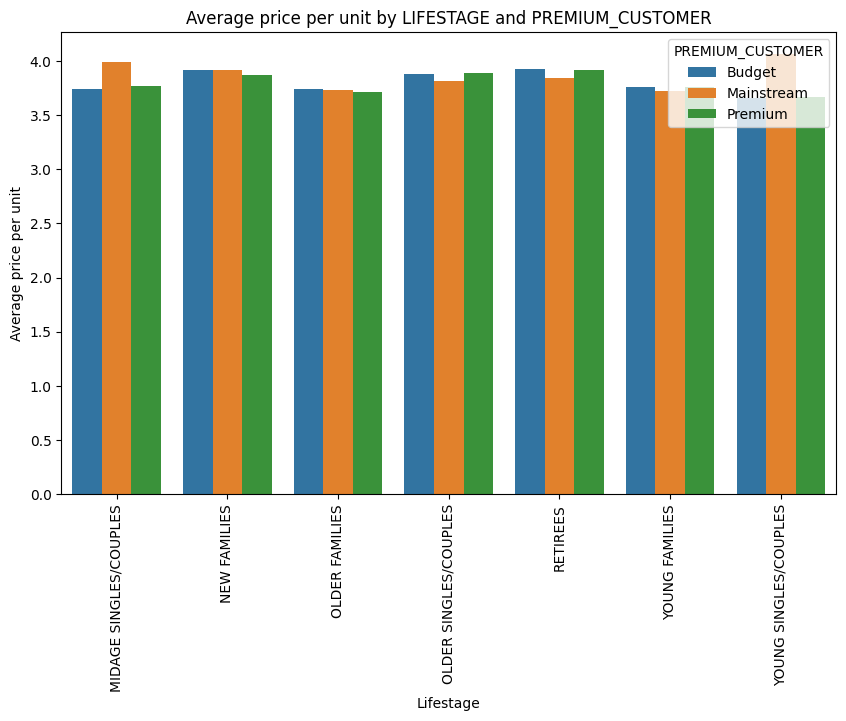

In [59]:
# Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
data['PRICE_PER_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']
print(data.head())

avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='LIFESTAGE', y='PRICE_PER_UNIT', hue='PREMIUM_CUSTOMER', data=avg_price)
plt.title('Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xlabel('Lifestage')
plt.ylabel('Average price per unit')
plt.xticks(rotation=90)
plt.show()

In [62]:
# Perform an independent t-test between mainstream vs premium and budget midage and young singles and couples
mainstream = data[(data['PREMIUM_CUSTOMER'] == 'Mainstream') & (data['LIFESTAGE'].isin(['MIDAGE SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES']))]['PRICE_PER_UNIT']
premium_budget = data[(data['PREMIUM_CUSTOMER'].isin(['Premium', 'Budget'])) & (data['LIFESTAGE'].isin(['MIDAGE SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES']))]['PRICE_PER_UNIT']
t_stat, p_value = ttest_ind(mainstream, premium_budget)
print(f"T-test p-value: {p_value}")

T-test p-value: 2.235645611549355e-309


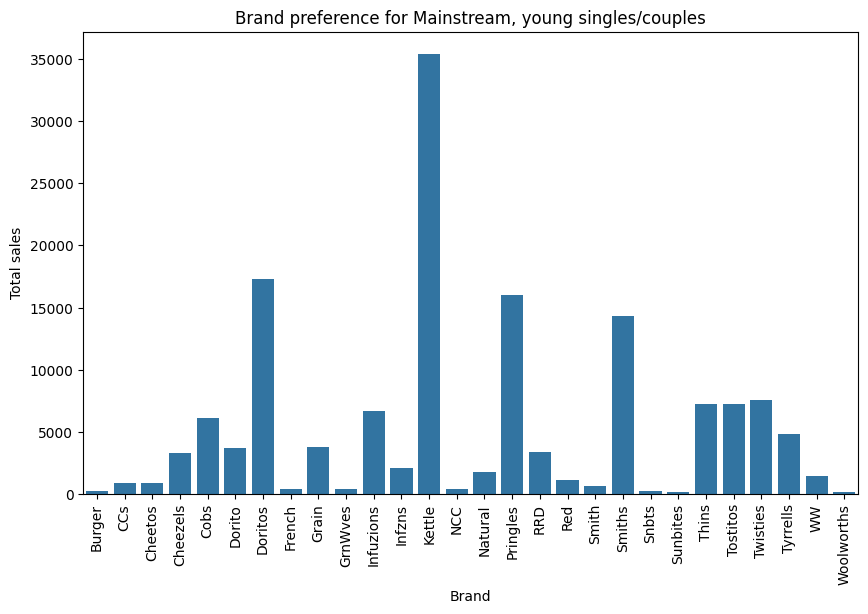

In [63]:
# Deep dive into Mainstream, young singles/couples
mainstream_young = data[(data['PREMIUM_CUSTOMER'] == 'Mainstream') & (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]
brand_preference = mainstream_young.groupby('BRAND')['TOT_SALES'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='BRAND', y='TOT_SALES', data=brand_preference)
plt.title('Brand preference for Mainstream, young singles/couples')
plt.xlabel('Brand')
plt.ylabel('Total sales')
plt.xticks(rotation=90)
plt.show()

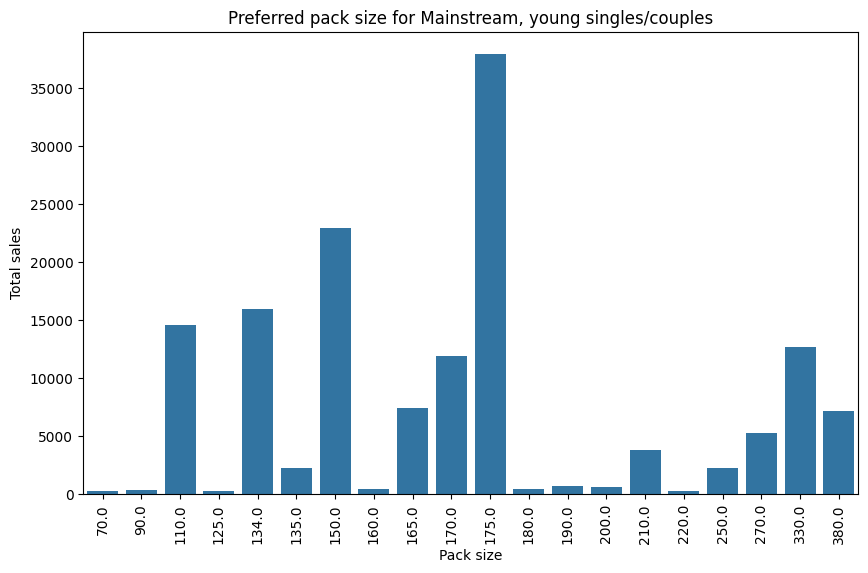

In [41]:
# Preferred pack size compared to the rest of the population
pack_size_preference = mainstream_young.groupby('PACK_SIZE')['TOT_SALES'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='PACK_SIZE', y='TOT_SALES', data=pack_size_preference)
plt.title('Preferred pack size for Mainstream, young singles/couples')
plt.xlabel('Pack size')
plt.ylabel('Total sales')
plt.xticks(rotation=90)
plt.show()